**PROJETO DISCIPLINA DE ALGORITMOS 1**

Aluno : Thiago Moura da Rocha Bastos

O objetivo desse trabalho e a utilização de dados de densidade óptica de perfis de filmes metálicos obtidos em processo industrial de metalização a vapor, para análise e classificação dos filmes produzido.

Motivação: Sabe-se que a densidade óptica dos filmes metálicos são variáveis essenciais para a qualidade do produto e a sua análise além de possibilitar predições de qualidade do produto formado, possibilita a análise das condições operacionais.

In [26]:
from google.colab import drive
import sys
try:
  drive.mount("/content/drive", force_remount=True)
  root  = '/content/drive/My Drive/projeto'
  sys.path.append(root)
except:
  print('erro encontrado')

Mounted at /content/drive


In [27]:
try:
  !pip install git+https://github.com/Borda/pyImSegm.git
  !pip install gco-wrapper
  !pip install shap
except:
  print('Erro de instalação shap')

  Cloning https://github.com/Borda/pyImSegm.git to /tmp/pip-req-build-chsusj9b
  Running command git clone -q https://github.com/Borda/pyImSegm.git /tmp/pip-req-build-chsusj9b
  Created wheel for ImSegm: filename=ImSegm-0.1.8-cp36-cp36m-linux_x86_64.whl size=513306 sha256=71047a3e6ab14b8b4056897f65405e3ba36b56ccebdc1b7c49adbe6f5909287c
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0msa1uw/wheels/a0/f3/67/a0f93bb9cd0b5e4c514982517e7fb87b122246c05e085bfa89
Successfully built ImSegm


In [128]:
import pandas
import numpy 
import tensorflow as tf
import datetime
import shap
from typing import List
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers
%matplotlib inline
import os, sys, glob, time
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import imsegm.utilities.data_io as tl_data
import imsegm.pipelines as segm_pipe
from __future__ import print_function
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

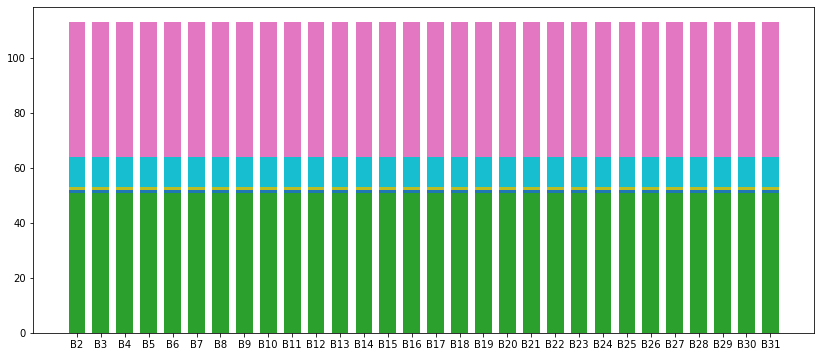

In [29]:
#Coleta de dados da tabela com os valores de Densidade Óptica (DO)
try:
  dbo_blocks= pandas.read_csv('/content/drive/My Drive/projeto/dbo_blocks.csv',error_bad_lines=False,encoding='ISO-8859-1',sep = ';')
except:
  print('Erro de importação da tabela dbo_blocks')

#Transformação da coluna "DateTime" para dados do tipo datetime
dbo_blocks['DateTime'] = pandas.to_datetime(dbo_blocks['DateTime'])

#Transformação do DataFrame em um dicionário de itens, cada item representa uma operação ou filme
aux = numpy.empty_like(dbo_blocks)
blocks_frame = numpy.empty_like(dbo_blocks)
blocks_dic = {}
j = 0
k = 0
for i in range(dbo_blocks.shape[0]):
  if ( i + 1 < dbo_blocks.shape[0]) and (dbo_blocks['Length'][i] < dbo_blocks['Length'][i+1]):
    aux = dbo_blocks.iloc[i]
    blocks_frame[j] = aux
    j +=1
  else:
    blocks_dic[k] = blocks_frame
    blocks_frame = pandas.DataFrame()
    j = 0
    k += 1
blocks_dic = { i: blocks_dic[i] for i in blocks_dic if blocks_dic[i].any != (0,0) }

#Importação de dados com as classificações dos filmes
#tabela com os dados compilados de processo e de qualidade, de onde vem as classes
try:  
  geral = pandas.read_csv('/content/drive/My Drive/projeto/Compilado_1_2.csv', error_bad_lines=False,sep = ';')
except:
  print('Erro de importação tabela geral')
geral = pandas.DataFrame.dropna(geral, axis = 0, how ='all')
geral = geral.reset_index()

#Retirada de conjuntos de valores nulos para comparação com a tabela geral para buscar as classes 
i = 0
k = 0
blocks_dic_new = {}
for i in range(len(blocks_dic)):
  if blocks_dic[i].shape != (0,0):
    blocks_dic_new[k] = blocks_dic[i]
    k += 1

#Os dados de classificação possuem a variável 'DepositStartTime' que é registrada 10 min e 16 s antes do primeiro dado de DO.

deltatime = datetime.timedelta(minutes=10, seconds = 16)
geral['DepositStartTime'] = pandas.to_datetime(geral['DepositStartTime'])

#Comparação entre os dados de tempo do primeiro registro de DO e dados de tempo de DepositStartTime
#Criação de um novo dicionário "bateladas", com os dados de D.O. relacionados a cada classificação

# Gerando um DataFrame para as classes 
l = 0
m = 0
k = 0
y = pandas.DataFrame(columns=['Situação'])
h = pandas.DataFrame(columns=['DepositStartTime'])
batelada = {}
for i in range(len(blocks_dic_new)):
  j = 0
  for j in range(geral.shape[0]):
    l = j
    m = i
    if (geral['DepositStartTime'][l] + deltatime) > blocks_dic_new[m][0][1] and (geral['DepositStartTime'][l] - deltatime) < blocks_dic_new[m][0][1]:
      y.loc[k] = geral['Situação'][l]
      h.loc[k] = geral['DepositStartTime'][l]
      batelada[k] = blocks_dic_new[m]
      k += 1 
results = pandas.concat([y,h], axis = 1)
#Transposição da matriz de densidades ópticas com classificações associadas
i = 0
for i in range(len(batelada)): batelada[i] = pandas.DataFrame.transpose(batelada[i])

#Retirada de variáveis não numéricas
i = 0
for i in range(143):
  batelada[i] = pandas.DataFrame.drop(batelada[i], columns=['ID','Length','DateTime','Fingerprint'])

i = 0
plt.rcParams["figure.figsize"] = (14, 6)
for i in range(len(batelada)):
  plt.bar(batelada[i].columns,len(batelada[i][:][:].values),width= 0.7)

#Retirada de variáveis que não contribuem para o treinamento
i = 0
for i in range(len(batelada)):
  batelada[i] = pandas.DataFrame.drop(batelada[i], columns=['B2','B25','B26','B27','B28','B29','B30','B31'])

#Transformação de dataframe para arrays
batelada_trunc = []
i = 0
for i in range(len(batelada)):
  batelada_trunc.append([])
  batelada_trunc[i] = batelada[i][:][:].values
  batelada_trunc[i] = numpy.asarray(batelada_trunc[i])
batelada_trunc = numpy.asarray(batelada_trunc)

#Transformação das labels "Aprovado" e "Reprovado" para numérico
#print(y)
def filtro(lista:List[str]) -> List[int]:
  if lista == []:
    return []
  else:
    aux = lista.pop(0)
    if aux == "Aprovado":
      return  [1] + filtro(lista)
    elif aux == "Reprovado":
      return [0] + filtro(lista)

y = list(filtro(list(pandas.DataFrame.values.fget(y))))

'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]

Exemplo n°:  0
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([458, 242, 703,  27]))
[[3 0 0 ..., 0 2 2]
 [2 0 2 ..., 3 2 2]
 [2 0 2 ..., 3 2 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]

Exemplo n°:  1
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([330, 919,  46, 135]))
[[2 3 1 ..., 3 1 1]
 [2 2 1 ..., 1 3 1]
 [2 2 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]

Exemplo n°:  2
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([565, 418, 360,  87]))
[[2 2 2 ..., 2 0 0]
 [0 2 2 ..., 3 0 0]
 [0 2 3 ..., 2 2 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]

Exemplo n°:  3
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([328, 390, 599, 113]))
[[1 2 3 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]

Exemplo n°:  4
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([795, 310, 189, 136]))
[[1 2 0 ..., 3 2 1]
 [1 0 0 ..., 3 2 1]
 [1 0 3 ..., 3 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]

Exemplo n°:  5
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([747, 290, 261, 132]))
[[1 2 0 ..., 3 2 1]
 [1 0 0 ..., 3 2 1]
 [1 0 0 ..., 3 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]

Exemplo n°:  6
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([289, 390, 740,  11]))
[[1 2 2 ..., 2 3 1]
 [1 0 2 ..., 2 2 1]
 [1 2 2 ..., 2 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]

Exemplo n°:  7
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([550, 205, 569, 106]))
[[0 3 2 ..., 2 3 0]
 [0 3 2 ..., 2 3 0]
 [0 3 2 ..., 2 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

Exemplo n°:  8
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([422, 959,   1,  48]))
[[0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]

Exemplo n°:  9
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([440, 470, 400, 120]))
[[0 0 2 ..., 1 0 0]
 [0 0 2 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]

Exemplo n°:  10
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([137, 934, 212, 147]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]

Exemplo n°:  11
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([792, 583,  26,  29]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

Exemplo n°:  12
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([290, 710, 288, 142]))
[[1 1 3 ..., 2 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]

Exemplo n°:  13
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([908, 146,  60, 316]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]

Exemplo n°:  14
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([890, 286, 245,   9]))
[[0 0 0 ..., 0 2 0]
 [3 2 2 ..., 0 0 0]
 [3 2 2 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]

Exemplo n°:  15
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([969, 308,  29, 124]))
[[0 0 0 ..., 0 0 0]
 [3 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]

Exemplo n°:  16
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([124, 308,  85, 913]))
[[2 0 3 ..., 3 3 2]
 [2 0 0 ..., 3 3 2]
 [3 3 3 ..., 3 3 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]

Exemplo n°:  17
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([765, 286, 108, 271]))
[[2 0 0 ..., 3 0 2]
 [2 3 3 ..., 3 0 2]
 [2 0 3 ..., 3 0 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]

Exemplo n°:  18
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([718, 530,  94,  88]))
[[1 3 2 ..., 2 0 1]
 [1 3 2 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

Exemplo n°:  19
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([355, 390, 638,  47]))
[[1 0 2 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 [1 3 2 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


Exemplo n°:  20
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([390, 783, 184,  73]))
[[0 1 2 ..., 2 1 0]
 [0 1 2 ..., 2 1 0]
 [0 1 2 ..., 2 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


Exemplo n°:  21
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([749, 603,  77,   1]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


Exemplo n°:  22
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([788, 390, 135, 117]))
[[1 2 0 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Exemplo n°:  23
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([604, 605,  80, 141]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


Exemplo n°:  24
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([250, 550, 564,  66]))
[[1 2 0 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


Exemplo n°:  25
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([788, 607,  22,  13]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Exemplo n°:  26
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([623, 575,  57, 175]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Exemplo n°:  27
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([319, 350,  90, 671]))
[[1 3 2 ..., 2 0 1]
 [1 3 3 ..., 2 0 1]
 [1 3 3 ..., 2 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


Exemplo n°:  28
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([248, 410, 159, 613]))
[[1 2 2 ..., 2 0 1]
 [1 0 2 ..., 2 2 1]
 [1 3 2 ..., 2 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


Exemplo n°:  29
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([867, 410,   8, 145]))
[[1 0 3 ..., 3 0 1]
 [1 0 3 ..., 3 0 1]
 [1 0 3 ..., 3 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Exemplo n°:  30
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([550, 574, 173, 133]))
[[0 3 2 ..., 1 3 0]
 [0 3 2 ..., 2 3 0]
 [0 3 2 ..., 2 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


Exemplo n°:  31
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 305, 492, 121]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


Exemplo n°:  32
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 535, 245, 138]))
[[0 0 2 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 3 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


Exemplo n°:  33
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([845, 512,  56,  17]))
[[1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 2 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Exemplo n°:  34
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([726, 321, 221, 162]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Exemplo n°:  35
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([386, 512, 465,  67]))
[[1 1 0 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]
 [1 1 3 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


Exemplo n°:  36
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 45, 494, 420, 471]))
[[1 1 3 ..., 3 1 1]
 [1 1 3 ..., 3 1 1]
 [1 1 3 ..., 3 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


Exemplo n°:  37
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([476, 722, 213,  19]))
[[0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


Exemplo n°:  38
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([704, 652,  30,  44]))
[[1 1 1 ..., 3 1 1]
 [1 1 2 ..., 3 1 1]
 [1 1 2 ..., 3 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


Exemplo n°:  39
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 612,  51, 255]))
[[0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


Exemplo n°:  40
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 635,  59, 224]))
[[0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Exemplo n°:  41
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([566, 293, 486,  85]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Exemplo n°:  42
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([336, 476, 172, 446]))
[[1 1 3 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 3 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


Exemplo n°:  43
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([151, 548, 479, 252]))
[[1 1 2 ..., 2 1 1]
 [1 1 2 ..., 0 1 1]
 [1 1 2 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


Exemplo n°:  44
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([421, 176, 787,  46]))
[[2 0 0 ..., 0 0 0]
 [2 0 0 ..., 0 2 2]
 [2 2 2 ..., 2 2 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


Exemplo n°:  45
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([396, 592, 288, 154]))
[[2 1 3 ..., 1 3 1]
 [1 1 3 ..., 1 1 2]
 [2 1 3 ..., 1 1 2]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


Exemplo n°:  46
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([726, 621,  49,  34]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


Exemplo n°:  47
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([505, 530, 183, 212]))
[[1 3 2 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


Exemplo n°:  48
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([602, 509, 270,  49]))
[[0 0 1 ..., 3 0 0]
 [0 0 1 ..., 3 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


Exemplo n°:  49
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([590, 350, 460,  30]))
[[1 2 0 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Exemplo n°:  50
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 97, 371,   7, 955]))
[[1 3 3 ..., 0 3 1]
 [1 3 3 ..., 3 3 1]
 [1 3 3 ..., 3 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


Exemplo n°:  51
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([955, 371,  97,   7]))
[[1 0 0 ..., 2 0 1]
 [1 0 0 ..., 0 0 1]
 [1 0 0 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


Exemplo n°:  52
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([410, 785, 132, 103]))
[[0 1 1 ..., 3 1 0]
 [0 1 1 ..., 3 1 0]
 [0 1 1 ..., 1 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


Exemplo n°:  53
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([313, 710,  16, 391]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]


Exemplo n°:  54
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([370, 900, 115,  45]))
[[0 1 1 ..., 2 3 0]
 [0 1 1 ..., 2 1 0]
 [0 1 2 ..., 2 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


Exemplo n°:  55
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([972, 350,  54,  54]))
[[1 3 0 ..., 0 2 1]
 [1 3 0 ..., 0 2 1]
 [1 3 0 ..., 0 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Exemplo n°:  56
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([537, 530, 230, 133]))
[[1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


Exemplo n°:  57
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 19, 458, 577, 376]))
[[1 1 3 ..., 3 1 1]
 [1 1 2 ..., 3 1 1]
 [1 1 3 ..., 3 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


Exemplo n°:  58
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 548, 253, 117]))
[[0 0 3 ..., 2 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 3 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


Exemplo n°:  59
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([918, 410,  51,  51]))
[[1 2 0 ..., 0 3 1]
 [1 2 0 ..., 0 3 1]
 [1 2 0 ..., 0 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


Exemplo n°:  60
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([854,  97,  64, 415]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Exemplo n°:  61
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([638, 657,  61,  74]))
[[1 1 3 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Exemplo n°:  62
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([134, 660, 206, 430]))
[[0 2 3 ..., 3 2 2]
 [3 2 3 ..., 3 3 3]
 [0 2 3 ..., 3 2 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Exemplo n°:  63
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([462, 342, 464, 162]))
[[2 1 3 ..., 3 3 1]
 [2 1 3 ..., 1 2 2]
 [2 2 1 ..., 3 1 2]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


Exemplo n°:  64
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([650, 308, 299, 173]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 3]
 [0 0 2 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


Exemplo n°:  65
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([653, 308, 441,  28]))
[[0 0 3 ..., 0 0 0]
 [2 0 2 ..., 2 0 0]
 [0 2 3 ..., 2 2 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


Exemplo n°:  66
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([214, 410, 795,  11]))
[[1 2 2 ..., 2 0 1]
 [1 2 2 ..., 0 0 1]
 [1 2 2 ..., 2 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


Exemplo n°:  67
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([903, 350,  58, 119]))
[[1 3 0 ..., 2 3 1]
 [1 0 0 ..., 2 3 1]
 [1 0 0 ..., 2 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


Exemplo n°:  68
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([550, 637, 150,  93]))
[[0 3 2 ..., 2 3 0]
 [0 1 2 ..., 2 3 0]
 [0 1 2 ..., 2 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Exemplo n°:  69
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([844, 390, 118,  78]))
[[1 0 0 ..., 2 3 1]
 [1 3 0 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Exemplo n°:  70
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([718, 390, 174, 148]))
[[1 0 2 ..., 2 3 1]
 [1 0 2 ..., 2 0 1]
 [1 3 0 ..., 3 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


Exemplo n°:  71
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([831, 264, 268,  67]))
[[0 2 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 2 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


Exemplo n°:  72
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([610, 726,  72,  22]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 2]
 [3 3 3 ..., 3 3 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


Exemplo n°:  73
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([839, 430,  78,  83]))
[[1 0 0 ..., 0 0 1]
 [1 0 0 ..., 0 0 1]
 [1 0 0 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


Exemplo n°:  74
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([310, 544, 536,  40]))
[[0 2 3 ..., 1 2 0]
 [0 2 1 ..., 1 2 0]
 [0 2 1 ..., 1 2 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


Exemplo n°:  75
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([332, 291, 558, 249]))
[[0 0 2 ..., 2 0 0]
 [0 0 1 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


Exemplo n°:  76
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([119, 146, 883, 282]))
[[1 0 3 ..., 3 0 1]
 [1 0 3 ..., 3 0 1]
 [1 0 3 ..., 3 0 1]
 ..., 
 [1 1 3 ..., 3 1 1]
 [1 1 2 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


Exemplo n°:  77
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1290,  124,    8,    8]))
[[0 2 1 ..., 1 3 0]
 [0 2 1 ..., 1 3 0]
 [0 2 1 ..., 1 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


Exemplo n°:  78
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([822, 290, 182, 136]))
[[1 3 2 ..., 2 3 1]
 [1 3 2 ..., 0 3 1]
 [1 3 2 ..., 0 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


Exemplo n°:  79
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 13, 410, 669, 338]))
[[1 2 3 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 [1 2 3 ..., 3 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


Exemplo n°:  80
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([156, 374, 822,  78]))
[[2 2 0 ..., 3 0 2]
 [2 2 2 ..., 3 0 2]
 [2 2 2 ..., 3 0 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


Exemplo n°:  81
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([128, 422, 699, 181]))
[[1 1 2 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Exemplo n°:  82
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([518, 816,  75,  21]))
[[0 0 2 ..., 3 0 0]
 [0 0 2 ..., 3 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


Exemplo n°:  83
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([530, 800,  63,  37]))
[[0 0 3 ..., 2 0 0]
 [0 0 3 ..., 2 0 0]
 [0 0 3 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


Exemplo n°:  84
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([454, 854,  61,  61]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


Exemplo n°:  85
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([286, 858, 197,  89]))
[[1 1 2 ..., 3 2 1]
 [1 1 2 ..., 3 2 1]
 [1 1 2 ..., 3 2 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Exemplo n°:  86
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([834, 494,  50,  52]))
[[1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 0 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


Exemplo n°:  87
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([736, 602,  46,  46]))
[[1 1 0 ..., 3 1 1]
 [1 1 0 ..., 3 1 1]
 [1 1 0 ..., 3 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


Exemplo n°:  88
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([286, 423,  22, 699]))
[[3 1 3 ..., 1 1 3]
 [2 2 2 ..., 2 2 2]
 [1 3 3 ..., 3 3 3]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


Exemplo n°:  89
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 121,  286,   22, 1001]))
[[3 3 3 ..., 3 3 3]
 [2 2 2 ..., 2 2 2]
 [3 3 3 ..., 3 3 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


Exemplo n°:  90
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([826, 286, 161, 157]))
[[3 2 0 ..., 0 2 3]
 [3 2 0 ..., 0 2 0]
 [3 2 0 ..., 0 2 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


Exemplo n°:  91
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([627, 286, 356, 161]))
[[2 0 2 ..., 2 0 2]
 [2 3 3 ..., 2 3 2]
 [2 3 3 ..., 2 3 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Exemplo n°:  92
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([338, 370, 688,  34]))
[[1 2 0 ..., 0 3 1]
 [1 0 2 ..., 0 2 1]
 [1 2 2 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


Exemplo n°:  93
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([827, 370,  19, 214]))
[[1 2 2 ..., 3 3 1]
 [1 3 2 ..., 2 3 1]
 [1 3 2 ..., 0 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


Exemplo n°:  94
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([510, 659, 178,  83]))
[[0 1 2 ..., 3 1 0]
 [0 1 2 ..., 3 1 0]
 [0 1 2 ..., 3 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


Exemplo n°:  95
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([932, 350,  80,  68]))
[[1 3 3 ..., 3 3 1]
 [1 3 0 ..., 3 3 1]
 [1 0 2 ..., 0 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


Exemplo n°:  96
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([410, 862, 148,  10]))
[[0 3 2 ..., 1 1 0]
 [0 1 2 ..., 1 1 0]
 [0 1 2 ..., 1 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


Exemplo n°:  97
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([876, 410, 104,  40]))
[[1 0 2 ..., 0 0 1]
 [1 0 2 ..., 0 0 1]
 [1 0 2 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Exemplo n°:  98
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([469, 110,  71, 780]))
[[3 0 0 ..., 2 0 3]
 [3 0 0 ..., 2 0 3]
 [3 0 0 ..., 2 0 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


Exemplo n°:  99
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([773, 480,  50, 127]))
[[1 2 0 ..., 0 1 1]
 [1 2 0 ..., 0 1 1]
 [1 2 0 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Exemplo n°:  100
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1290,  121,    3,   16]))
[[0 3 1 ..., 1 2 0]
 [0 2 3 ..., 1 3 0]
 [0 3 1 ..., 1 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


Exemplo n°:  101
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1310,   99,    6,   15]))
[[0 2 1 ..., 1 3 0]
 [0 2 1 ..., 1 3 0]
 [0 2 1 ..., 3 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


Exemplo n°:  102
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 509,  55, 354]))
[[0 0 3 ..., 3 0 0]
 [0 0 3 ..., 3 0 0]
 [0 0 3 ..., 3 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Exemplo n°:  103
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 87, 584, 752,   7]))
[[1 1 3 ..., 3 1 1]
 [1 1 3 ..., 0 1 1]
 [1 1 3 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


Exemplo n°:  104
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([494, 751, 104,  81]))
[[0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 [0 0 2 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


Exemplo n°:  105
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([347, 620,  47, 416]))
[[1 1 3 ..., 2 1 1]
 [1 1 3 ..., 2 1 1]
 [1 1 3 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


Exemplo n°:  106
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([510, 584, 292,  44]))
[[1 1 0 ..., 0 1 1]
 [1 1 0 ..., 3 1 1]
 [1 1 0 ..., 3 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


Exemplo n°:  107
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([154, 512, 759,   5]))
[[1 1 0 ..., 2 1 1]
 [1 1 2 ..., 0 1 1]
 [1 1 2 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Exemplo n°:  108
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([512, 824,  63,  31]))
[[0 0 1 ..., 2 0 0]
 [0 0 1 ..., 2 0 0]
 [0 0 1 ..., 2 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


Exemplo n°:  109
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([918, 308, 128,  76]))
[[0 2 0 ..., 3 2 0]
 [3 2 2 ..., 3 2 3]
 [0 2 0 ..., 3 2 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


Exemplo n°:  110
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1070,  330,   18,   12]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


Exemplo n°:  111
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1070,  330,   18,   12]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Exemplo n°:  112
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 330, 1000,   50,   50]))
[[3 1 1 ..., 1 1 2]
 [3 1 1 ..., 1 1 2]
 [3 1 1 ..., 1 1 2]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Exemplo n°:  113
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([477, 308, 585,  60]))
[[2 2 0 ..., 3 0 2]
 [0 0 0 ..., 3 0 2]
 [2 0 0 ..., 3 0 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Exemplo n°:  114
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([476, 622, 273,  59]))
[[0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 [0 0 1 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


Exemplo n°:  115
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([1080,  224,   95,   31]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


Exemplo n°:  116
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([308, 410, 649,  63]))
[[1 2 0 ..., 2 2 1]
 [1 2 0 ..., 0 2 1]
 [1 2 0 ..., 0 2 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


Exemplo n°:  117
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([410, 597, 247, 176]))
[[0 1 3 ..., 2 2 0]
 [0 2 1 ..., 2 1 0]
 [0 2 3 ..., 2 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


Exemplo n°:  118
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([792, 494, 117,  27]))
[[1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


Exemplo n°:  119
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([894,  22, 362, 152]))
[[2 2 2 ..., 2 0 0]
 [2 2 0 ..., 2 0 0]
 [0 0 0 ..., 2 0 0]
 ..., 
 [0 3 0 ..., 2 0 0]
 [0 0 0 ..., 2 0 0]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


Exemplo n°:  120
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([410, 787,  57, 176]))
[[0 2 3 ..., 3 2 0]
 [0 2 3 ..., 1 1 0]
 [0 2 3 ..., 1 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


Exemplo n°:  121
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([103, 308, 234, 785]))
[[0 2 3 ..., 0 2 3]
 [0 2 3 ..., 0 2 3]
 [3 2 3 ..., 0 2 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


Exemplo n°:  122
Classe:  Reprovado 
 (array([1, 2, 3], dtype=int32), array([ 308,    6, 1116]))
[[3 3 3 ..., 3 3 3]
 [3 3 3 ..., 3 3 3]
 [3 3 3 ..., 3 3 3]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


Exemplo n°:  123
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([868, 410,  44, 108]))
[[1 3 2 ..., 0 0 1]
 [1 3 2 ..., 0 0 1]
 [1 3 2 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


Exemplo n°:  124
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([410, 637, 129, 254]))
[[0 3 2 ..., 2 3 0]
 [0 3 2 ..., 2 3 0]
 [0 3 2 ..., 2 3 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


Exemplo n°:  125
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([789, 440, 120,  81]))
[[2 3 0 ..., 2 3 0]
 [2 0 0 ..., 2 3 0]
 [0 0 0 ..., 2 3 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Exemplo n°:  126
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([630, 700,  50,  50]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


Exemplo n°:  127
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([730, 505, 112,  83]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


Exemplo n°:  128
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([217, 908, 250,  55]))
[[1 1 2 ..., 0 1 1]
 [1 1 2 ..., 0 1 1]
 [1 1 2 ..., 0 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Exemplo n°:  129
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([836, 328, 147, 119]))
[[0 0 1 ..., 1 0 0]
 [0 0 3 ..., 1 0 0]
 [0 0 3 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


Exemplo n°:  130
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([151, 918, 281,  80]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


Exemplo n°:  131
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([934, 277, 142,  77]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


Exemplo n°:  132
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([181, 934, 238,  77]))
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


Exemplo n°:  133
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([854, 422, 115,  39]))
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


Exemplo n°:  134
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([542, 410, 238, 240]))
[[1 0 2 ..., 2 0 1]
 [1 3 2 ..., 2 0 1]
 [1 3 2 ..., 2 0 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Exemplo n°:  135
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([764, 293, 187, 186]))
[[0 0 3 ..., 3 0 0]
 [0 0 1 ..., 3 0 0]
 [0 0 3 ..., 1 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Exemplo n°:  136
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([234, 782, 192, 222]))
[[1 1 2 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]
 [1 1 2 ..., 2 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


Exemplo n°:  137
Classe:  Reprovado 
 (array([0, 1, 2, 3], dtype=int32), array([607, 308, 431,  84]))
[[2 0 0 ..., 0 0 2]
 [2 0 2 ..., 0 0 2]
 [0 0 2 ..., 2 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


Exemplo n°:  138
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([314, 264, 756,  96]))
[[2 3 2 ..., 0 0 2]
 [2 0 2 ..., 2 0 2]
 [2 3 2 ..., 0 0 2]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


Exemplo n°:  139
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 308, 1098,   13,   11]))
[[2 1 1 ..., 1 1 2]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


Exemplo n°:  140
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([286, 536, 482, 126]))
[[1 2 3 ..., 3 2 1]
 [3 2 1 ..., 1 2 3]
 [1 2 1 ..., 1 2 3]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
'compute SLIC & features' @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


Exemplo n°:  141
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([955, 308, 116,  51]))
[[0 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 3]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Exemplo n°:  142
Classe:  Aprovado 
 (array([0, 1, 2, 3], dtype=int32), array([ 87, 410, 288, 645]))
[[1 3 2 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 [1 3 2 ..., 2 3 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


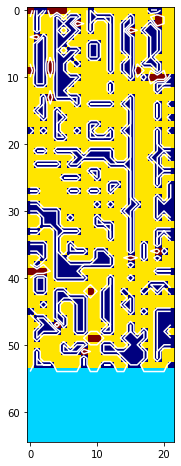

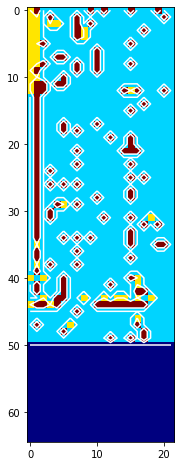

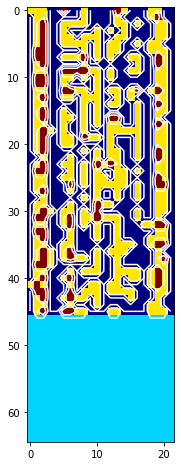

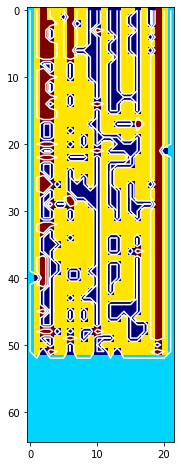

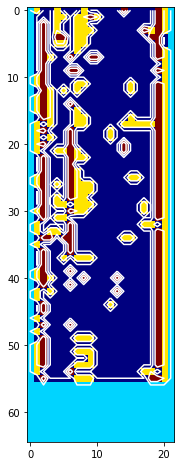

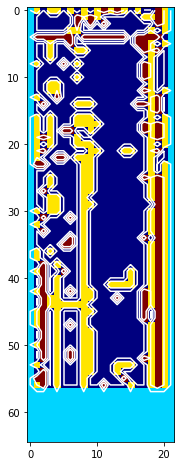

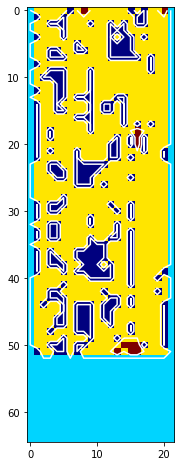

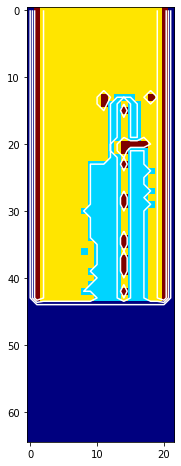

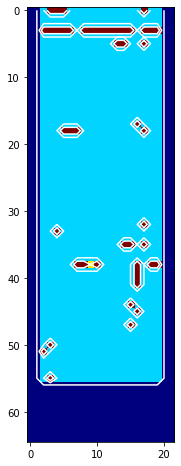

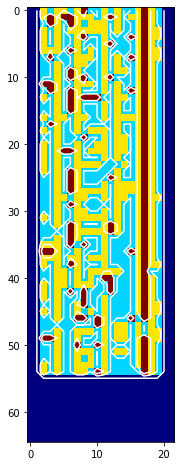

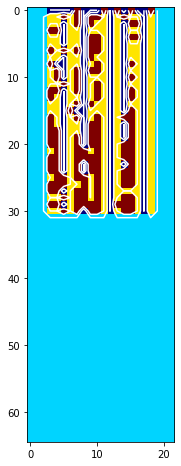

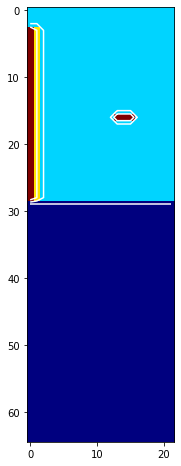

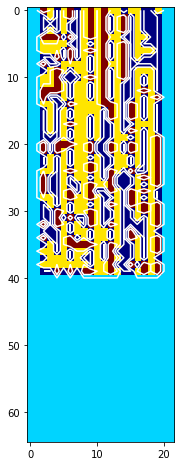

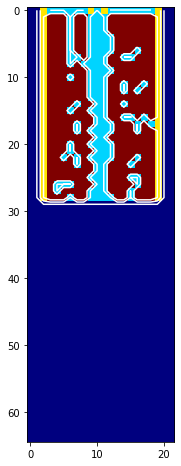

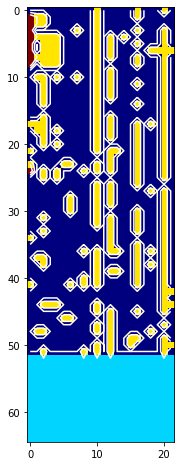

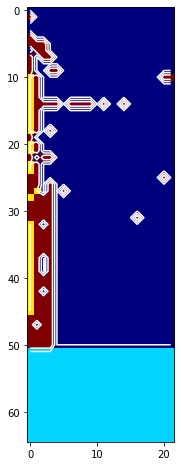

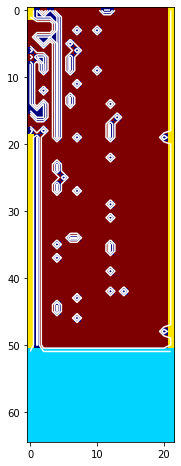

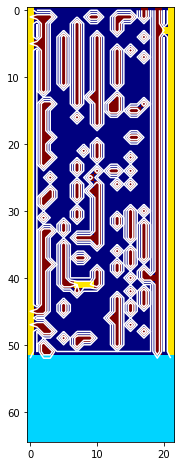

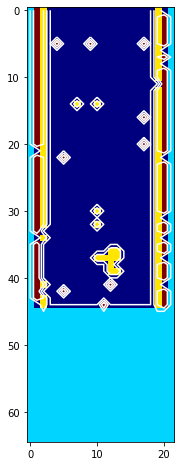

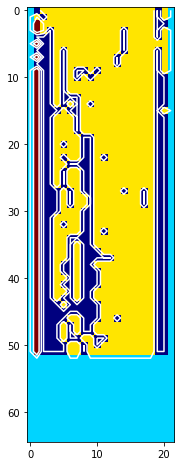

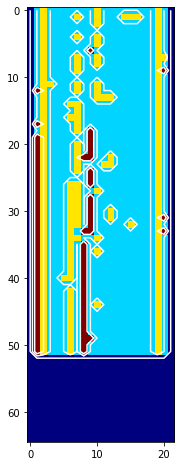

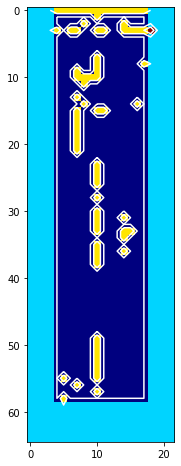

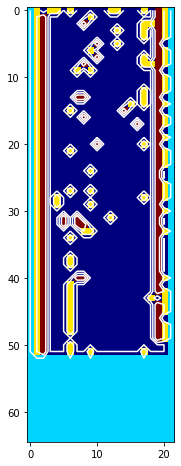

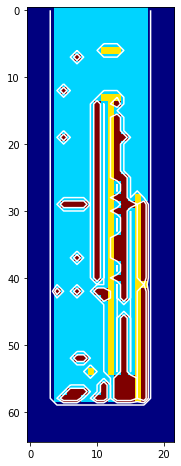

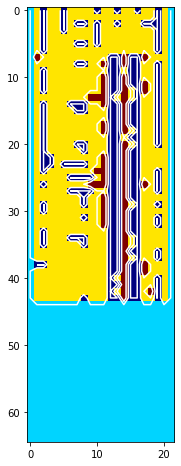

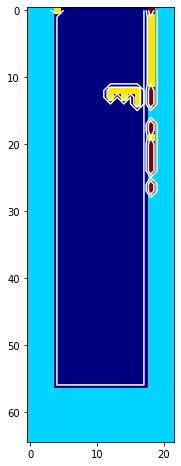

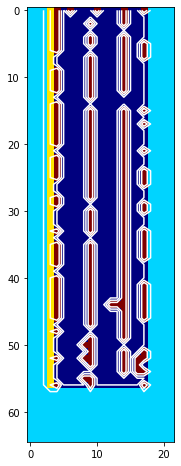

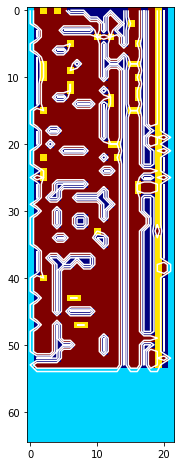

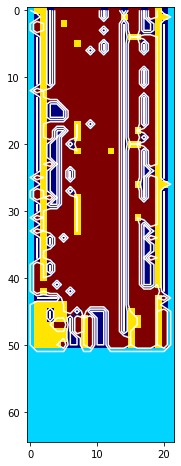

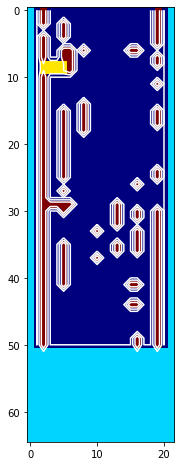

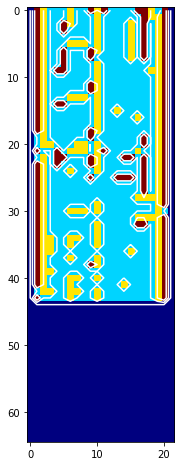

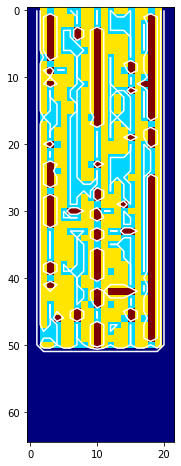

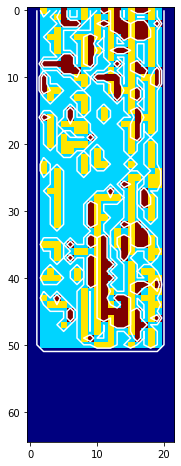

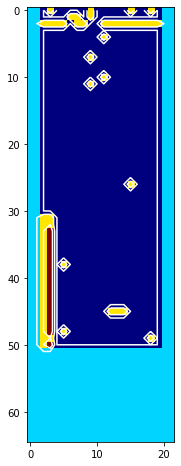

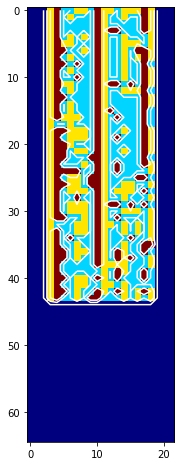

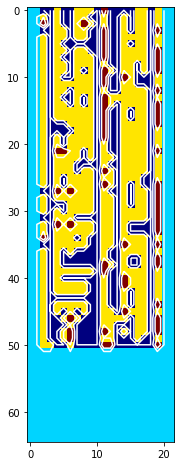

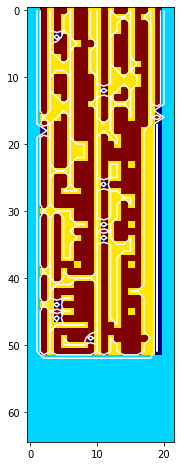

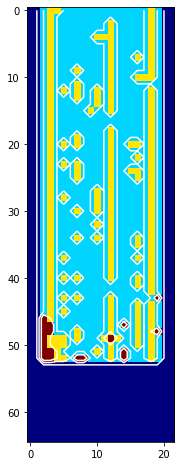

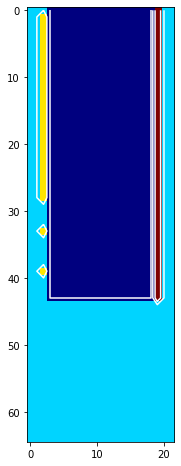

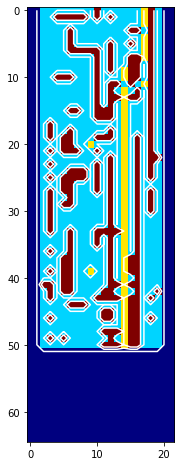

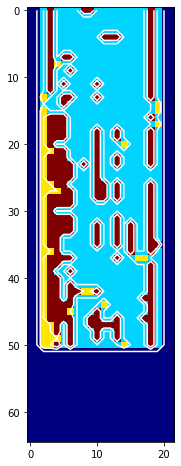

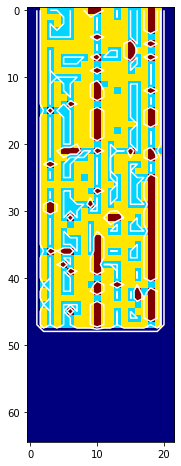

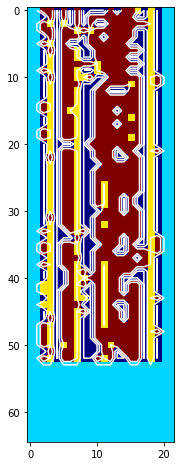

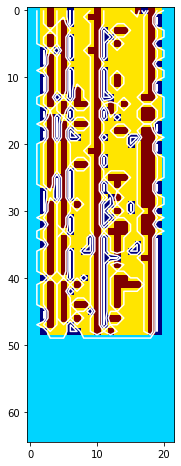

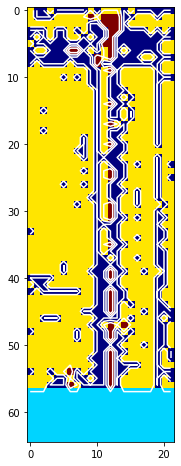

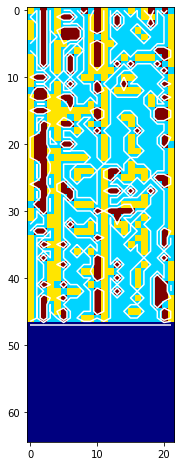

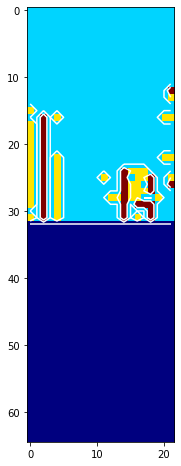

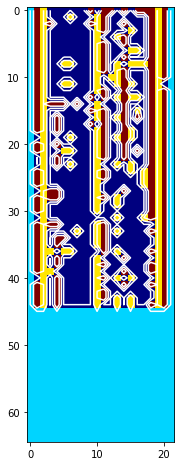

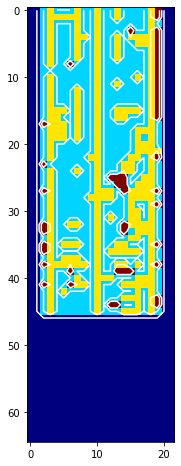

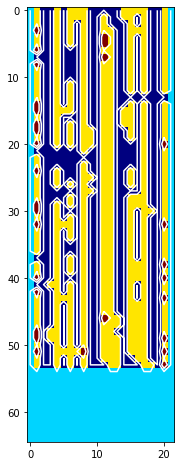

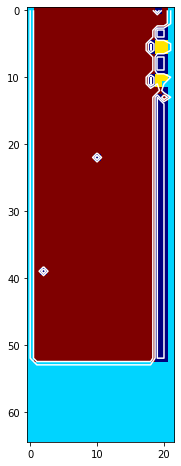

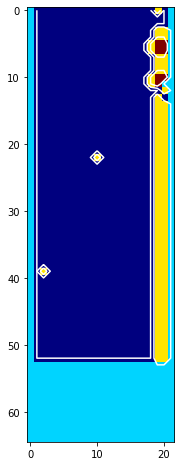

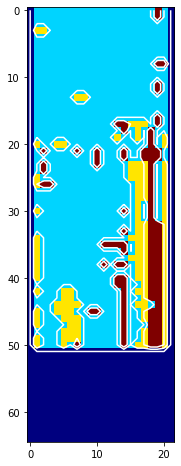

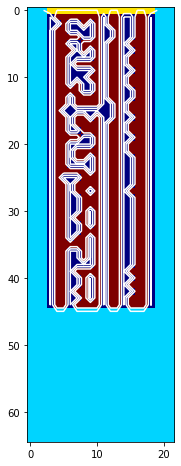

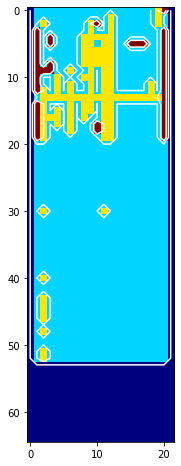

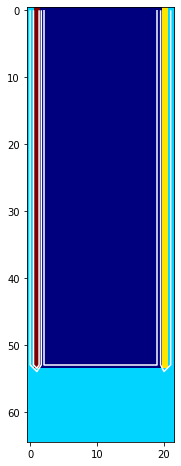

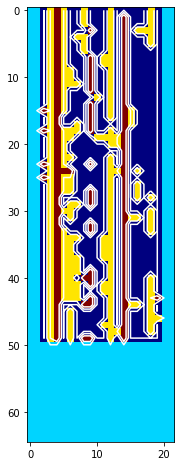

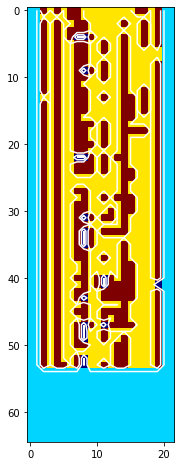

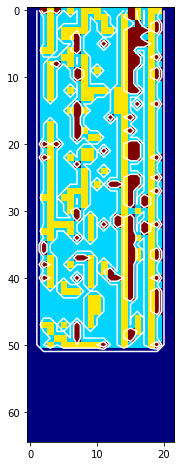

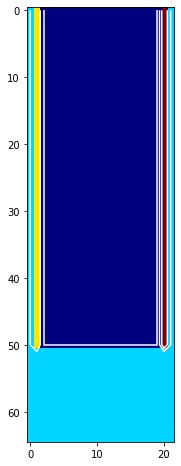

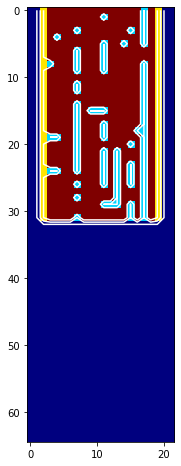

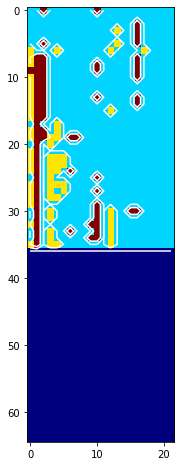

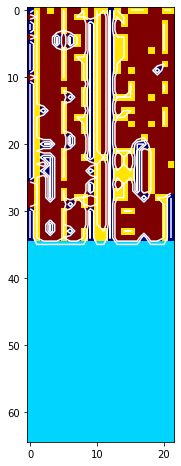

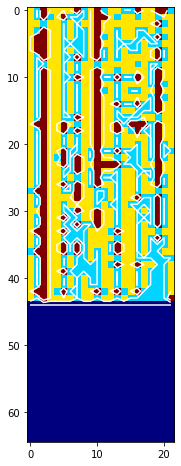

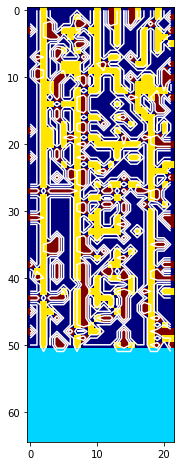

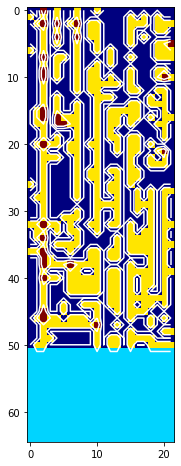

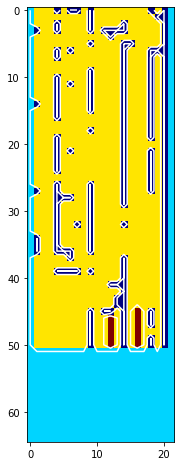

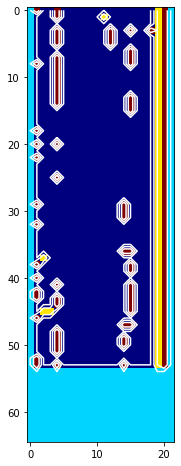

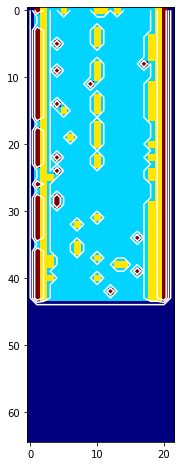

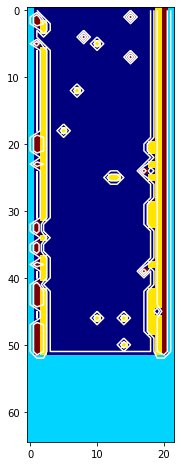

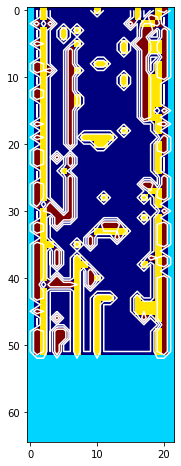

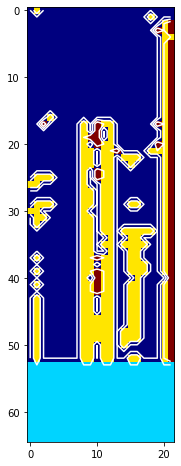

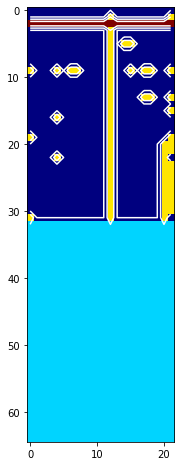

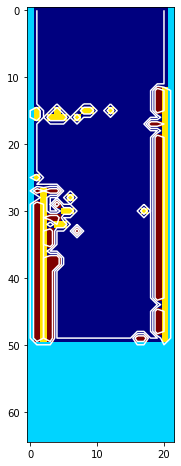

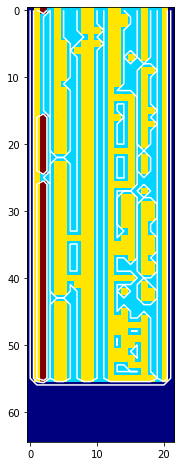

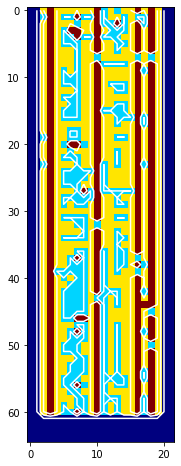

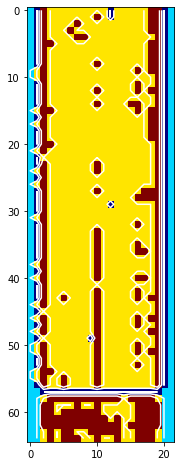

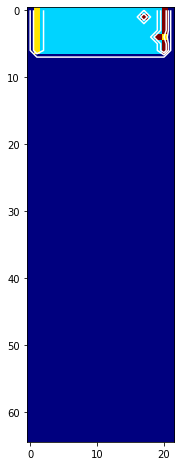

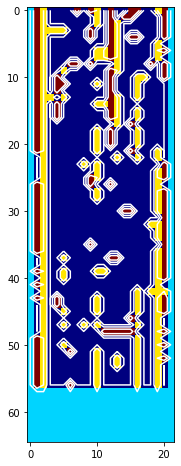

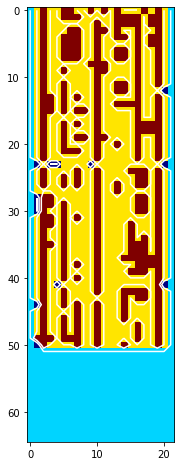

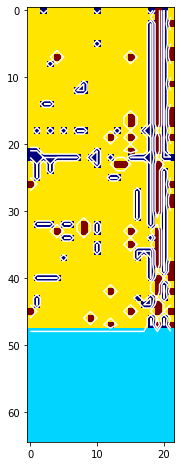

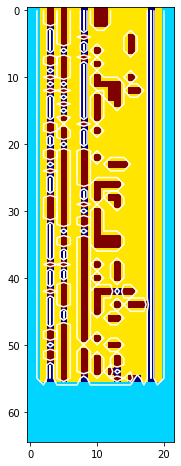

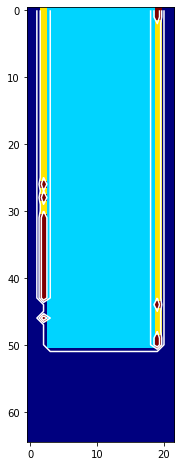

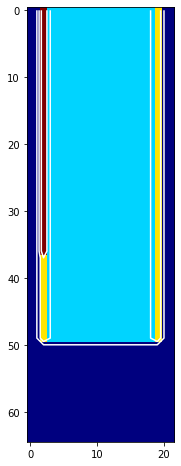

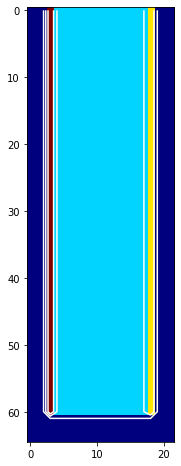

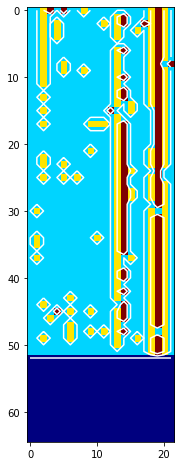

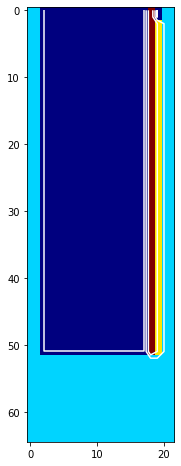

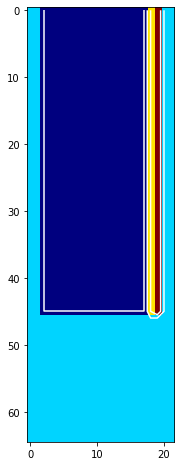

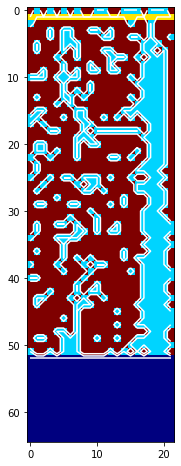

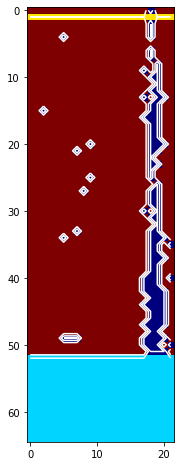

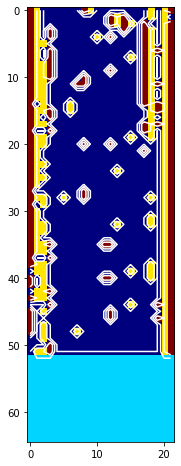

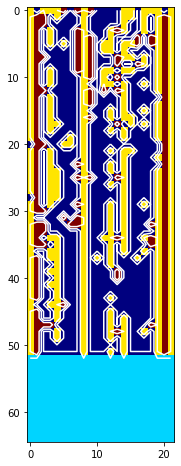

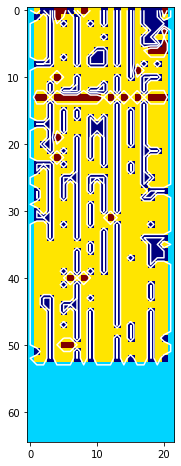

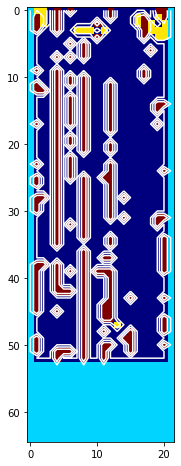

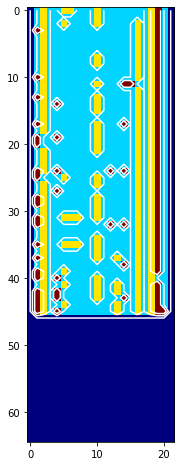

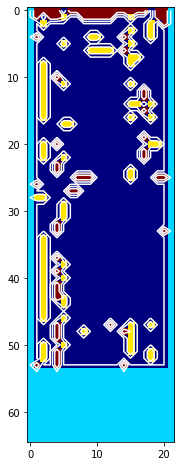

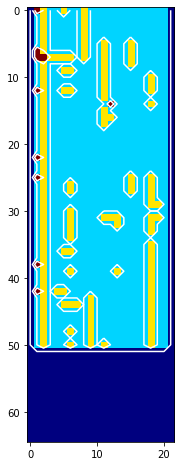

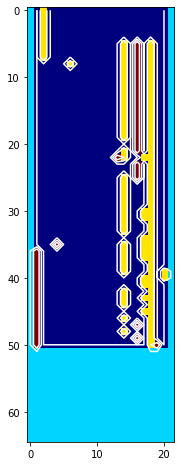

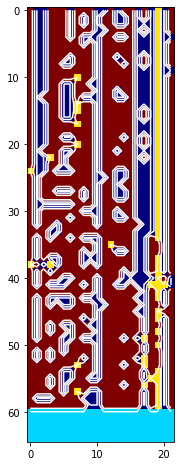

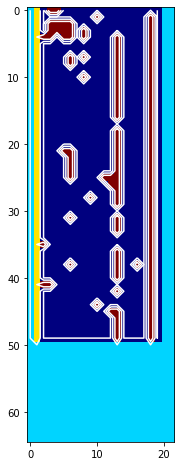

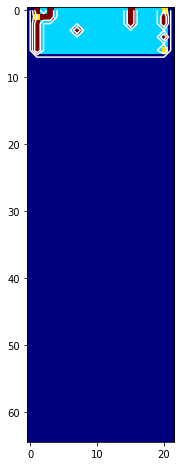

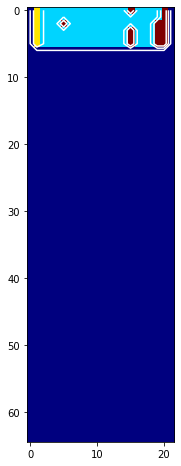

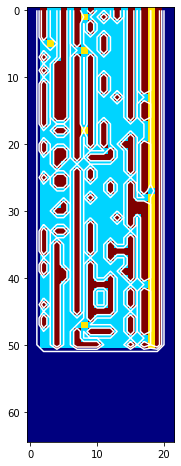

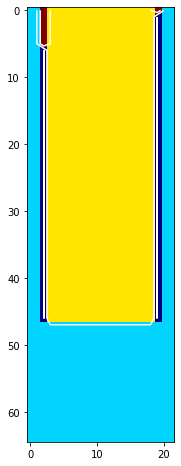

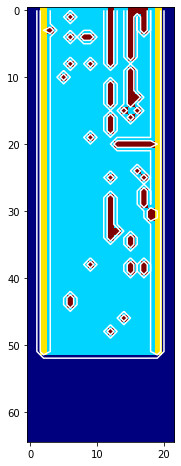

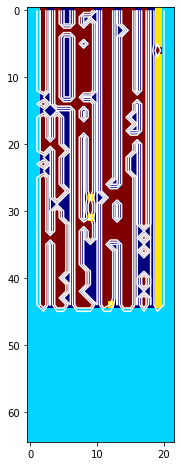

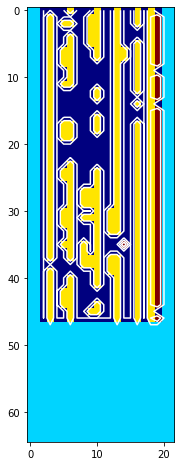

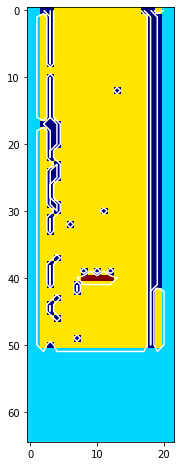

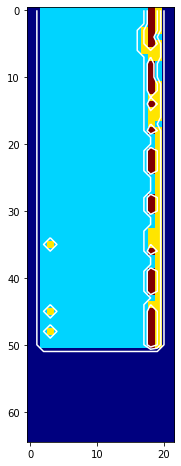

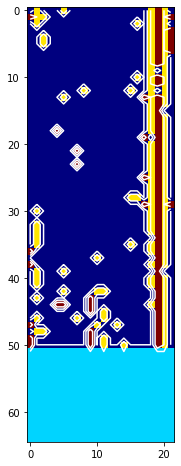

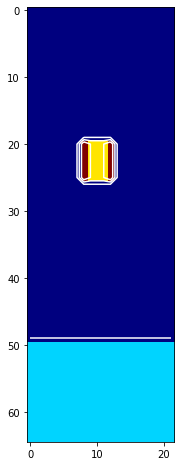

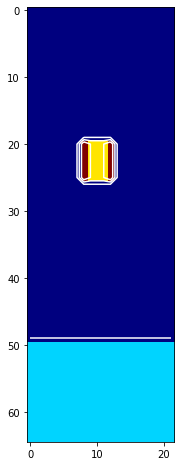

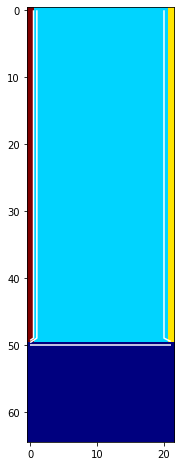

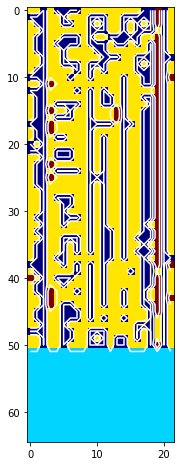

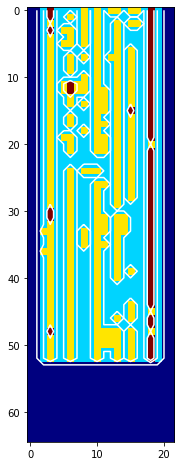

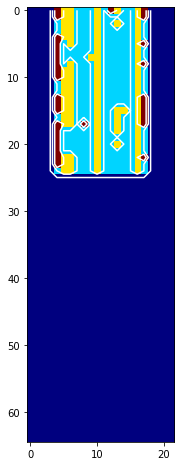

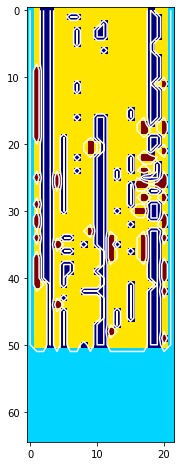

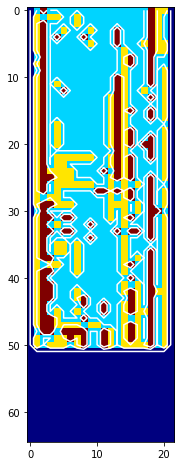

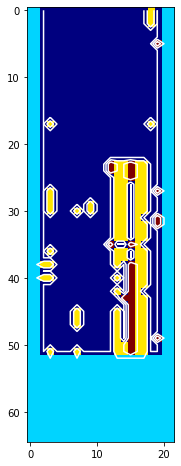

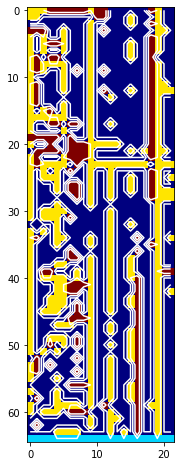

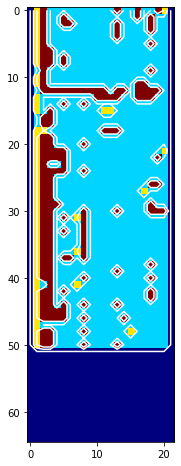

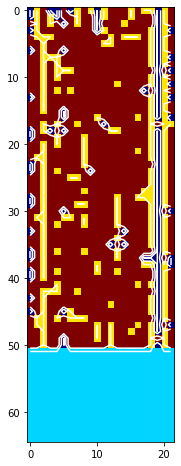

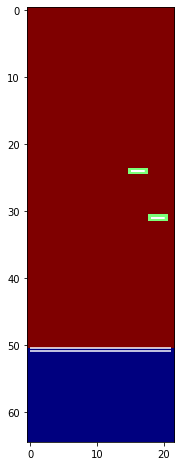

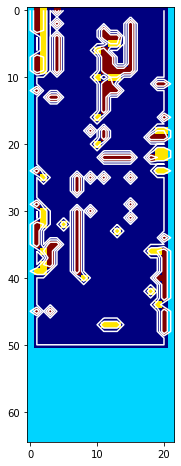

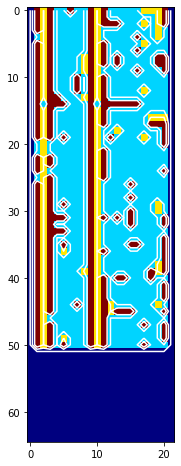

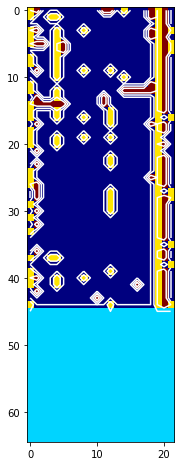

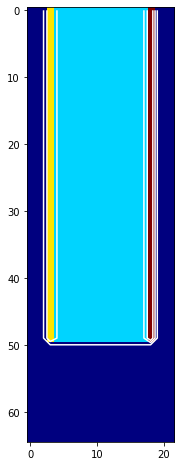

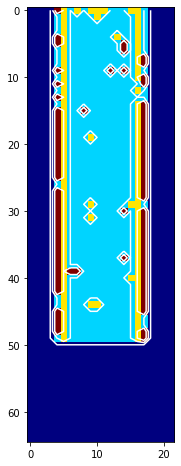

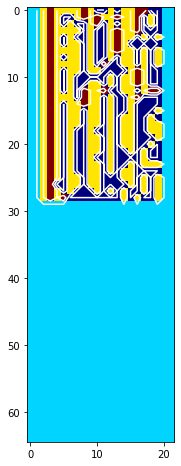

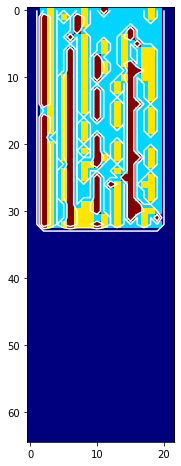

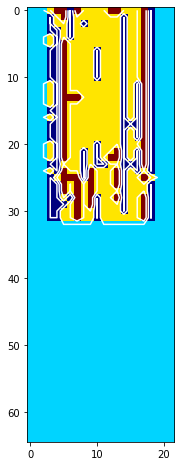

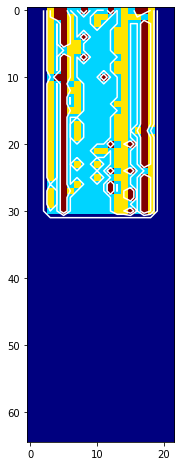

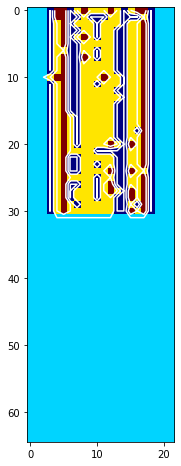

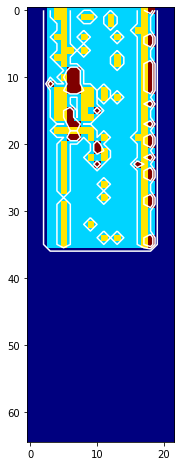

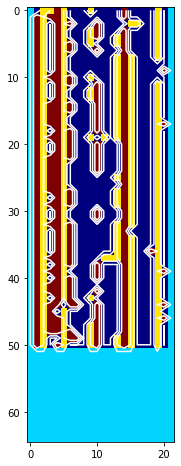

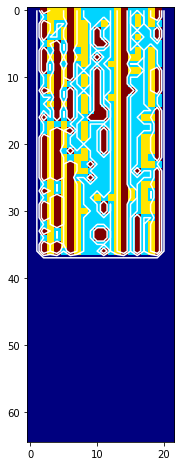

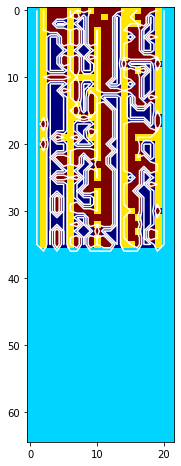

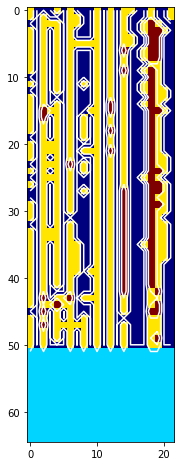

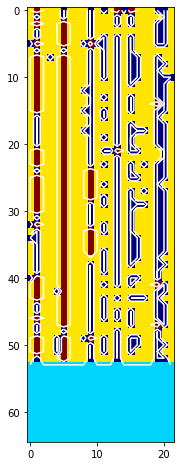

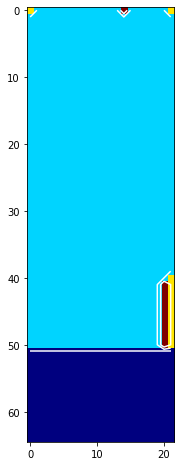

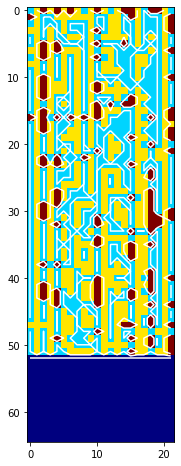

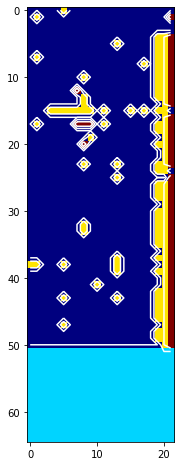

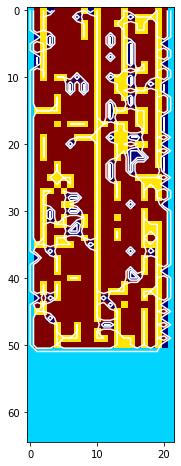

In [32]:
#Criação de tensores para treinamento de rede neural e tratamento como imagem
tensores = tf.keras.preprocessing.sequence.pad_sequences(batelada_trunc, maxlen= 65, padding = 'post', value = 0, dtype= float, truncating= 'post')

#Transformação das labels de dataframe para numpy array
target = numpy.array(y).astype(numpy.float32)
segments = []
#Amostra supervised segmentation on images
i = 0
for i in range(len(tensores)):
  img = tensores[i]
  #_= plt.imshow(img)
  FIG_SIZE = (8. * numpy.array(img.shape[:2]) / numpy.max(img.shape))[::-1]
  nb_classes = 4
  sp_size = 1
  sp_regul = 0.1
  dict_features = {'color': ['mean', 'std', 'median']}
  #modelo baseado na segmentação da imagme em classes
  model, _ = segm_pipe.estim_model_classes_group([img], nb_classes, sp_size=sp_size, sp_regul=sp_regul, 
                                          dict_features=dict_features, pca_coef=True, model_type='GMM')
  dict_debug = {}
  seg, _ = segm_pipe.segment_color2d_slic_features_model_graphcut(img, model, sp_size=sp_size, sp_regul=sp_regul,
                dict_features=dict_features, gc_regul=1., gc_edge_type='color', debug_visual=dict_debug)
  segments.append(seg)
  fig = plt.figure(figsize=FIG_SIZE)
  print('Exemplo n°: ', str(i))
  plt.imshow(img)
  plt.imshow(seg, cmap=plt.cm.jet)
  _= plt.contour(seg, levels=numpy.unique(seg), colors='w')
  print('Classe: ', 'Aprovado' if y[i] == 1 else 'Reprovado', '\n', numpy.unique(seg, return_counts=True))
  print(seg)
  

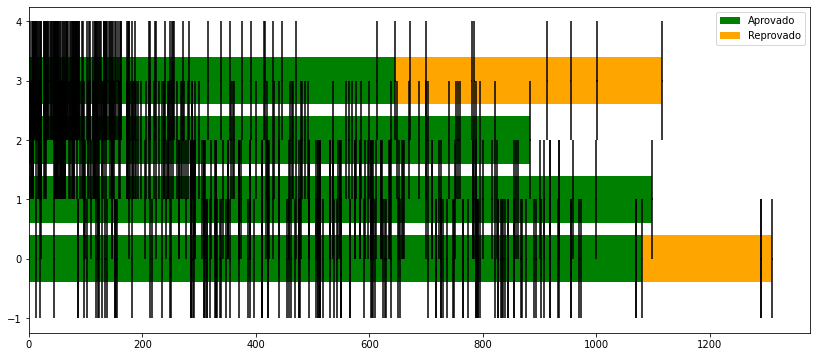

In [124]:
lista_classes = []
i = 0
for i in range(len(segments)): 
  lista_classes.append(numpy.unique(segments[i], return_counts=True)[1])
i = 0
plt.rcParams["figure.figsize"] = (14, 6)
for i in range(len(lista_classes)):
  plt.barh(numpy.unique(segments[i], return_counts=True)[0],lista_classes[i], color = 'green' if y[i] == 1 else 'orange', xerr = True, yerr = True, align = 'center', label = 'Aprovado' if y[i] == 1 else 'Reprovado')
  if i < 2:
    plt.legend()

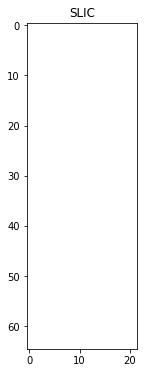

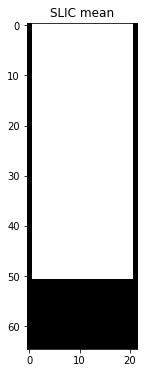

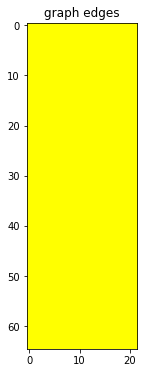

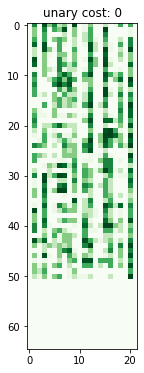

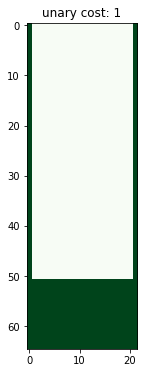

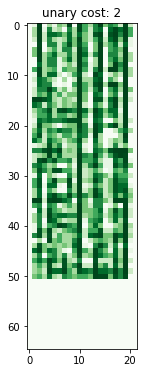

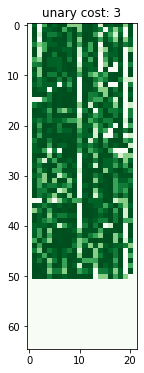

In [125]:
plt.figure(), plt.imshow(mark_boundaries(tensores[i], dict_debug['slic'], color=(1, 1, 1))), plt.title('SLIC')
plt.figure(), plt.imshow(dict_debug['slic_mean']), plt.title('SLIC mean')
plt.figure(), plt.imshow(dict_debug['img_graph_edges']), plt.title('graph edges')
for i, im_u in enumerate(dict_debug['imgs_unary_cost']):
    plt.figure(), plt.title('unary cost: %i' % i), plt.imshow(im_u)

In [129]:
batch_size = 2
num_classes = 2
epochs = 20

#dimensões de imagem
img_rows, img_cols = 65, 22

# separação do dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(tensores,target, stratify = target)

#configuração do formato dos dados para adaptação a rede neural

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Construção de modelo de rede neural de forma sequencial
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#compilação da rede neural
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
#treinamento da rede
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

#Análise de desempenho
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
54/54 [==============================] - 0s 8ms/step - loss: 0.5762 - accuracy: 0.8131 - val_loss: 0.5015 - val_accuracy: 0.8611
Epoch 2/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4987 - accuracy: 0.8505 - val_loss: 0.4611 - val_accuracy: 0.8611
Epoch 3/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4769 - accuracy: 0.8505 - val_loss: 0.4416 - val_accuracy: 0.8611
Epoch 4/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.8505 - val_loss: 0.4324 - val_accuracy: 0.8611
Epoch 5/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4550 - accuracy: 0.8505 - val_loss: 0.4267 - val_accuracy: 0.8611
Epoch 6/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4456 - accuracy: 0.8505 - val_loss: 0.4228 - val_accuracy: 0.8611
Epoch 7/20
54/54 [==============================] - 0s 4ms/step - loss: 0.4551 - accuracy: 0.8505 - val_loss: 0.4205 - val_accuracy: 0.8611
Epoch 8/20
54/54 [==

Exemplo n°:  0
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


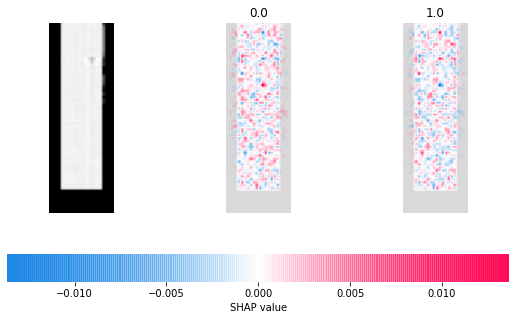

Exemplo n°:  1


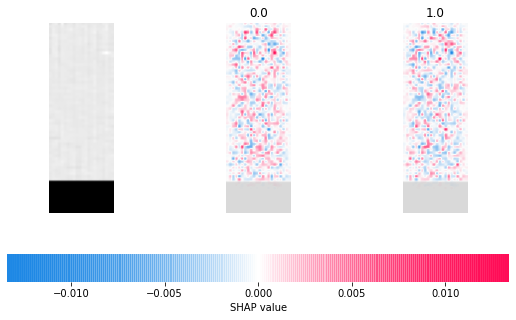

Exemplo n°:  2


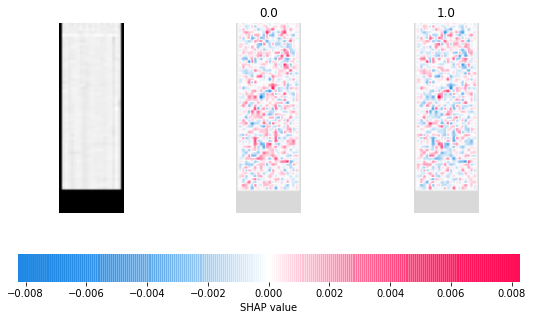

Exemplo n°:  3


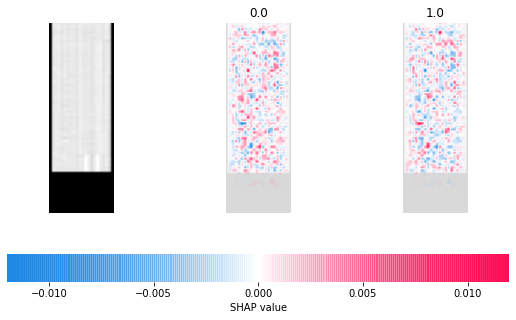

Exemplo n°:  4


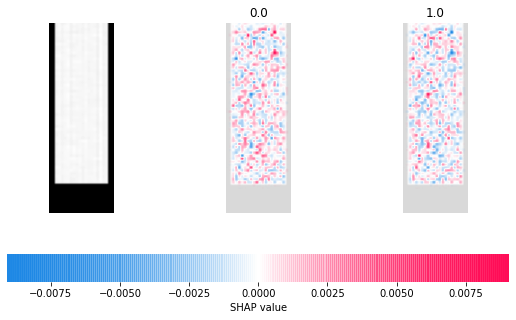

Exemplo n°:  5


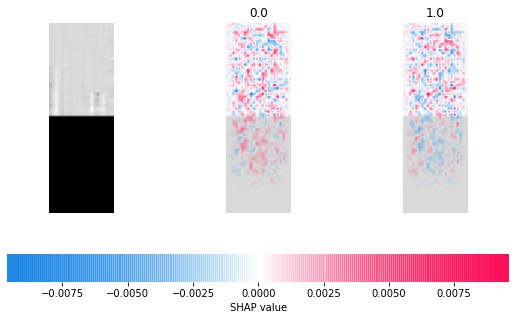

Exemplo n°:  6


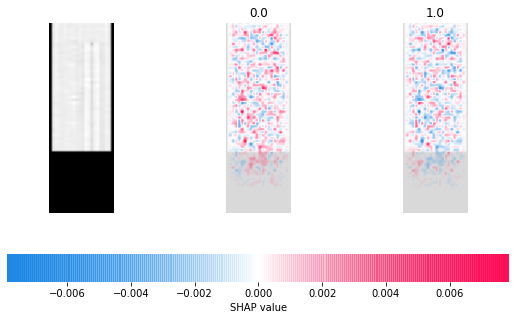

Exemplo n°:  7


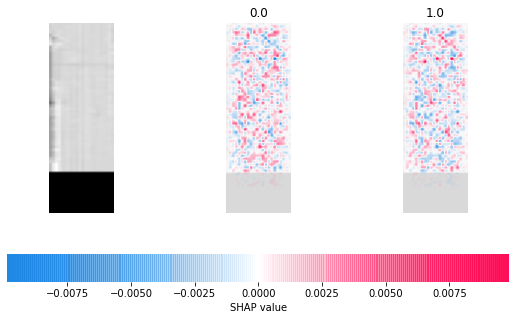

Exemplo n°:  8


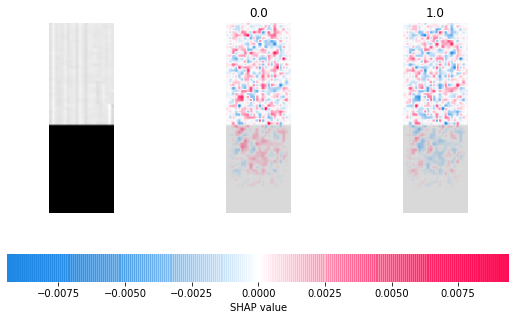

Exemplo n°:  9


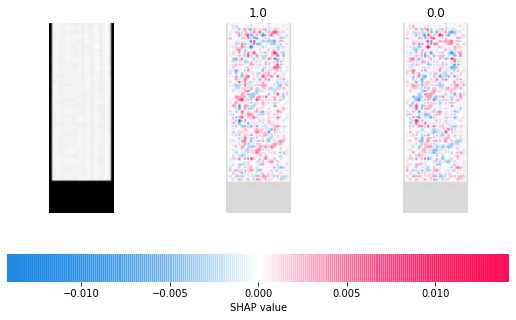

Exemplo n°:  10


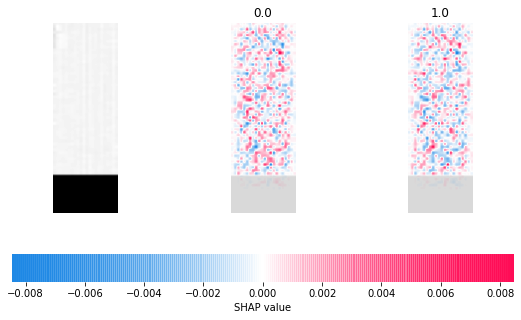

Exemplo n°:  11


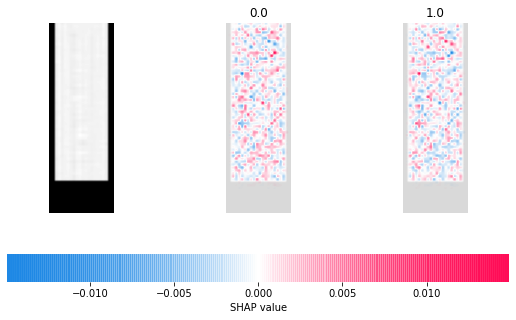

Exemplo n°:  12


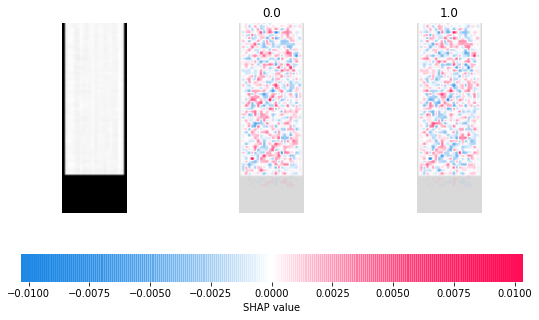

Exemplo n°:  13


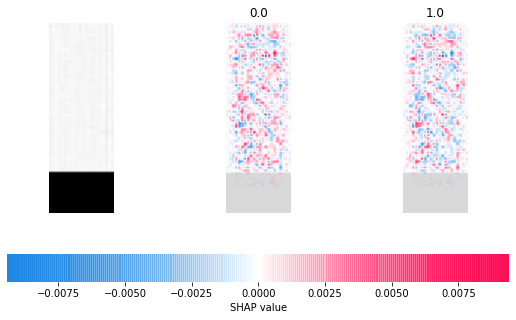

Exemplo n°:  14


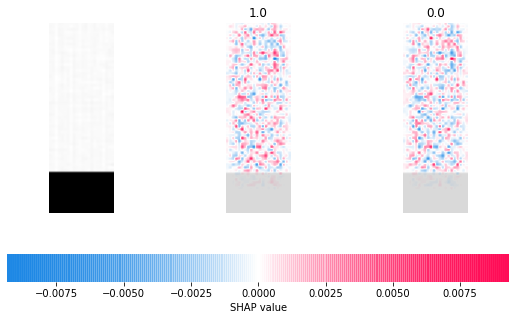

Exemplo n°:  15


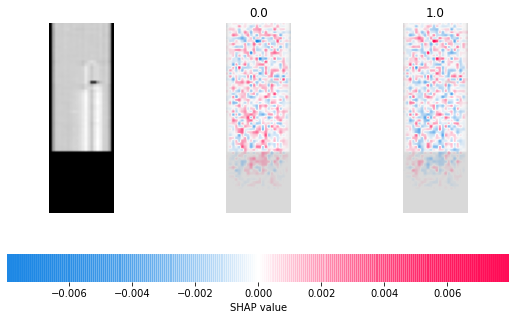

Exemplo n°:  16


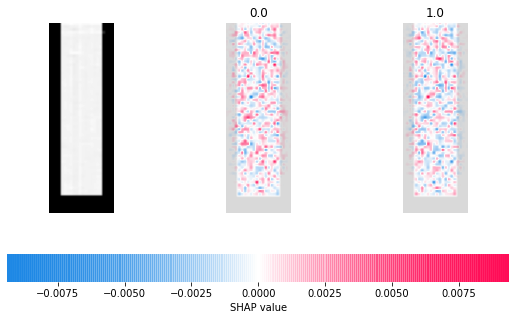

Exemplo n°:  17


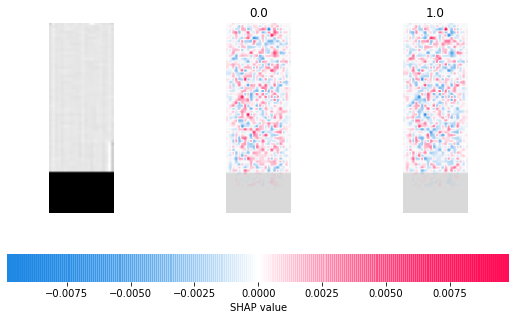

Exemplo n°:  18


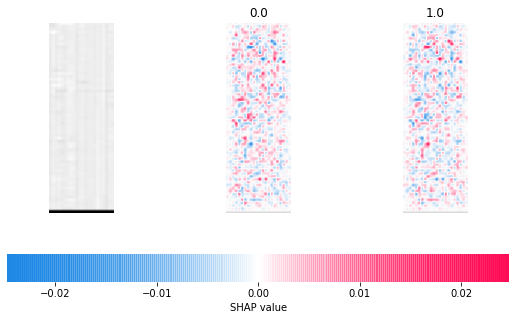

Exemplo n°:  19


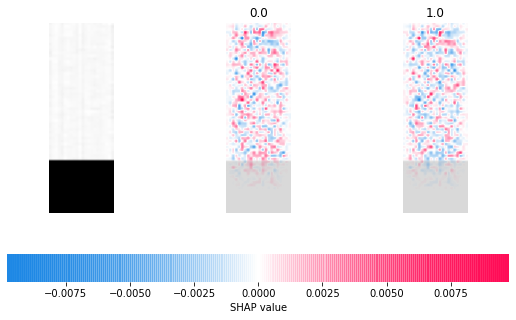

Exemplo n°:  20


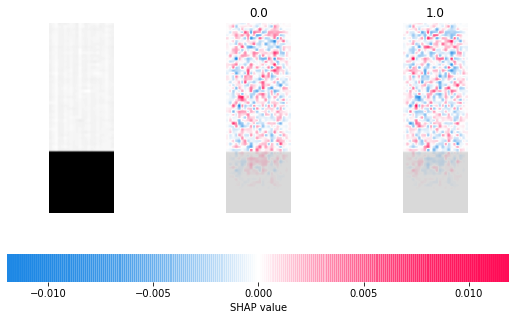

Exemplo n°:  21


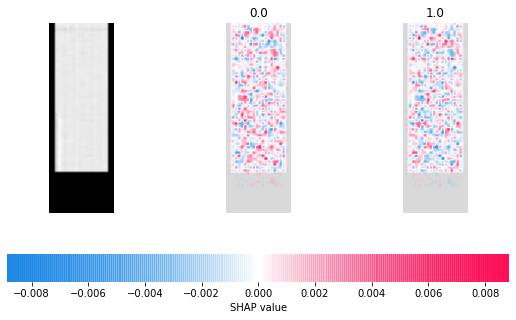

Exemplo n°:  22


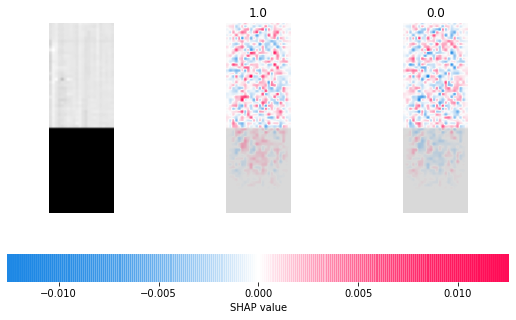

Exemplo n°:  23


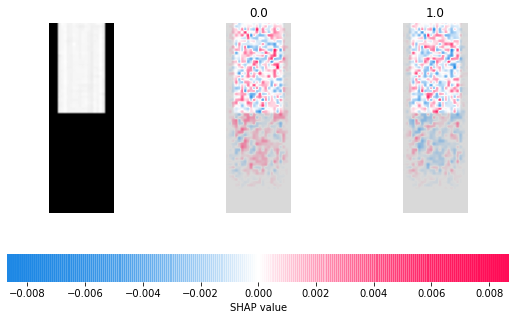

Exemplo n°:  24


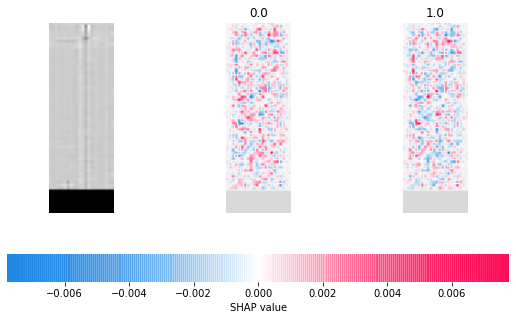

Exemplo n°:  25


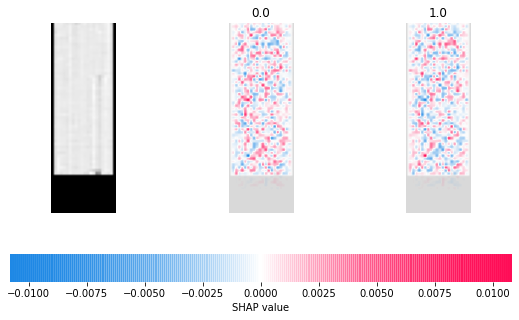

Exemplo n°:  26


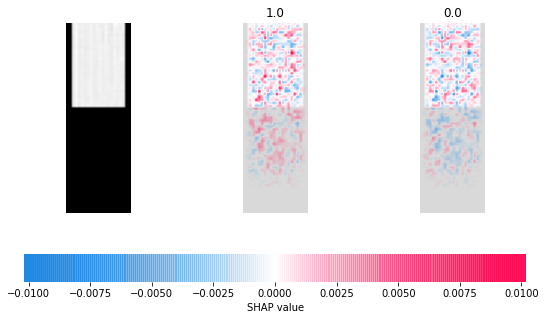

Exemplo n°:  27


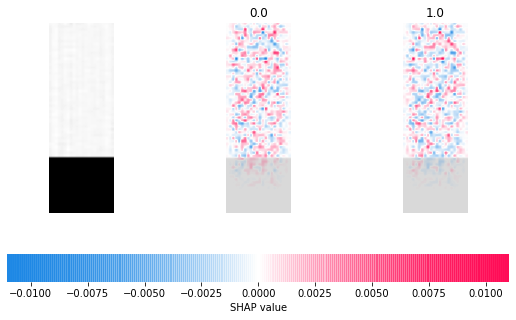

Exemplo n°:  28


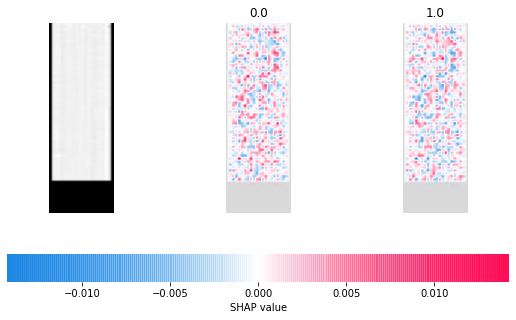

Exemplo n°:  29


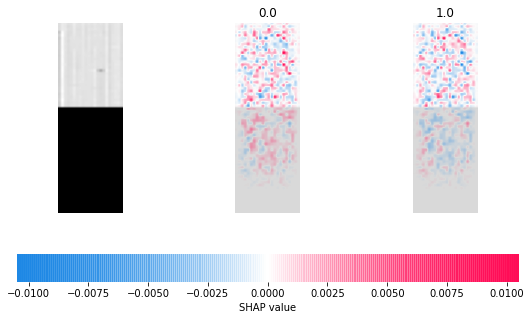

Exemplo n°:  30


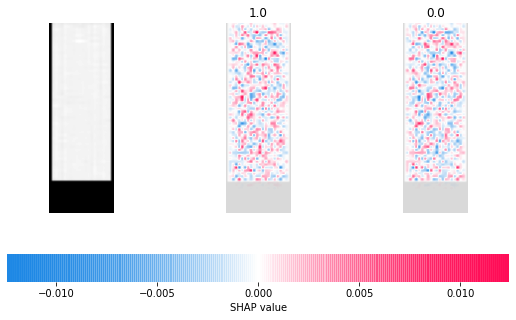

Exemplo n°:  31


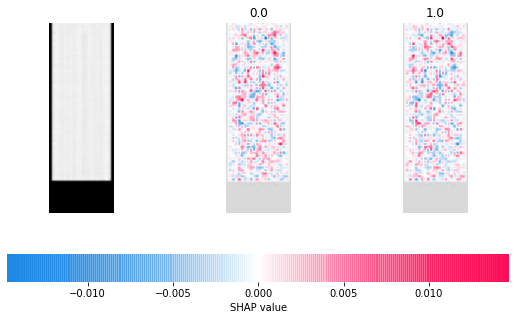

Exemplo n°:  32


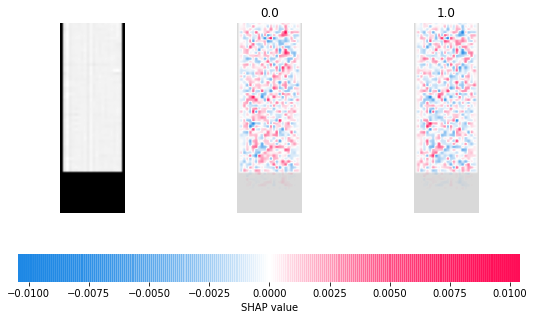

Exemplo n°:  33


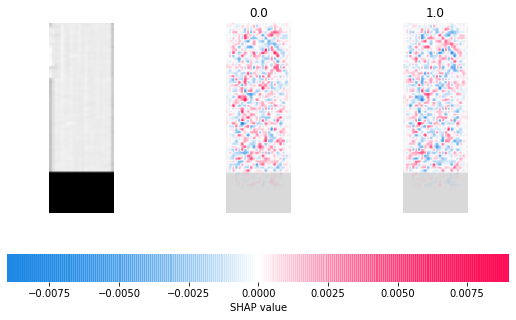

Exemplo n°:  34


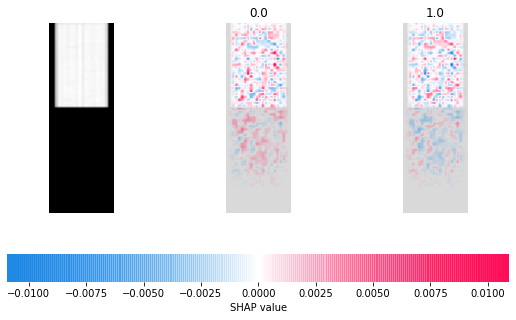

Exemplo n°:  35


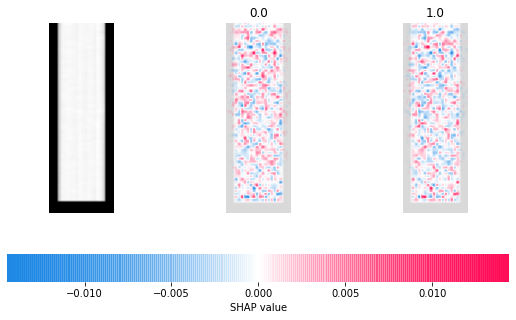

In [130]:
shap_values_dic = {}

# dados de treino nos quais o modelo foi construído
background = x_train[numpy.random.choice(x_train.shape[0], 20, replace=False)]

# Explicação do modelo para as classes
e1 = shap.DeepExplainer(model, background)
e2 = shap.GradientExplainer(model, background)

shap_values_dic['DeepExplainer'] = {}
shap_values_dic['GradientExplainer']= {}
# plot dos pesos espacialmente distribuídos
i = 4
for i in range(len(x_test)):
  print('Exemplo n°: ', str(i))
  shap_values1 = e1.shap_values(-x_test[i:i+1])
  #print('shap_value - DeepExplainer', str(sum(sum(sum(sum(shap_values1))))))
  shap.image_plot(shap_values1, x_test[i:i+1],labels = y_test[i:i+1], width= 10, hspace=0.2,aspect= 0.5)
  shap_values2 = e2.shap_values(-x_test[i:i+1])
  #print('shap_value - GradientExplainer', str(sum(sum(sum(sum(shap_values2))))))
  #shap.image_plot(shap_values2, x_test[i:i+1],labels = y_test[i:i+1], width= 10, hspace=0.2,aspect= 0.5) 
  shap_values_dic['DeepExplainer'][i] = sum(sum(sum(sum(shap_values1))))
  shap_values_dic['GradientExplainer'][i] = sum(sum(sum(sum(shap_values2))))
#A classe verdadeira é a imagem da direita

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


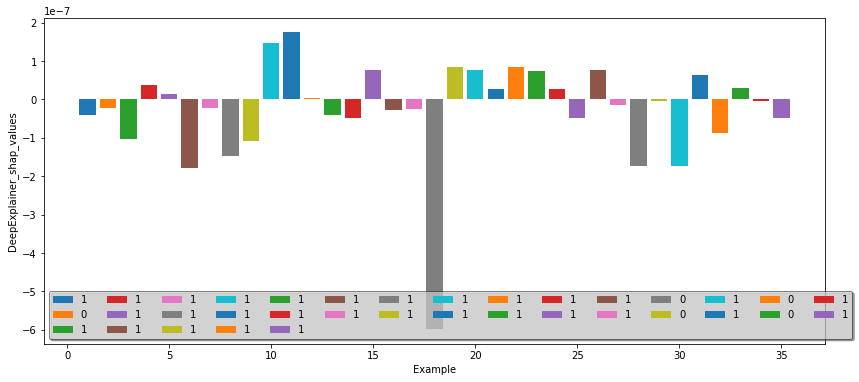

In [132]:
i = 0
plt.rcParams["figure.figsize"] = (14, 6)
for i in range(len(shap_values_dic['DeepExplainer'])):
  plt.bar(i,shap_values_dic['DeepExplainer'][i])
  plt.legend(edgecolor = "inherit", labels = y, loc = 'best', shadow = bool,framealpha = 0.5, ncol = 15)
  plt.axes(ylabel = 'DeepExplainer_shap_values', xlabel = 'Example')
i = 0
#for i in range(len(shap_values_dic['DeepExplainer'])):
#  plt.bar(i,shap_values_dic['GradientExplainer'][i])
#  plt.legend(edgecolor = "inherit", labels = y, loc = 'best', shadow = bool,framealpha = 0.5, ncol = 15)
#  plt.axes(ylabel = 'GradientExplainer_shap_values', xlabel = 'Example')

**Trabalhos Futuros**



*   Analisar porcentagem das classes mostradas;
*   Determinar thresholds de porcentagem de classe para reprovação do produto
*   Identificação de padrões de falhas e classificação



